# 💼 Projeto – Clustering Hierárquico

Um **Marketplace especializado** oferece um amplo catálogo de **laptops e notebooks** de diversas configurações e marcas, mantendo um estoque limitado para pronta entrega.  
Quando um item não está em estoque, o pedido junto ao fabricante resulta em **atrasos**, o que pode frustrar os clientes.

---

## 🎯 Objetivo

Para mitigar esse problema, o Marketplace planeja implementar um **sistema de recomendação** que sugira alternativas com **configurações similares** aos produtos indisponíveis.

---

## 🛠️ Solução Proposta

Para isso, desenvolveremos um:

- 🔍 **Algoritmo de clusterização hierárquica**  
  Para agrupar equipamentos semelhantes com base em suas especificações.

- 💡 **Interface de consulta baseada na clusterização**  
  Permitirá aos clientes encontrar **produtos alternativos** dentro do mesmo grupo do item selecionado.


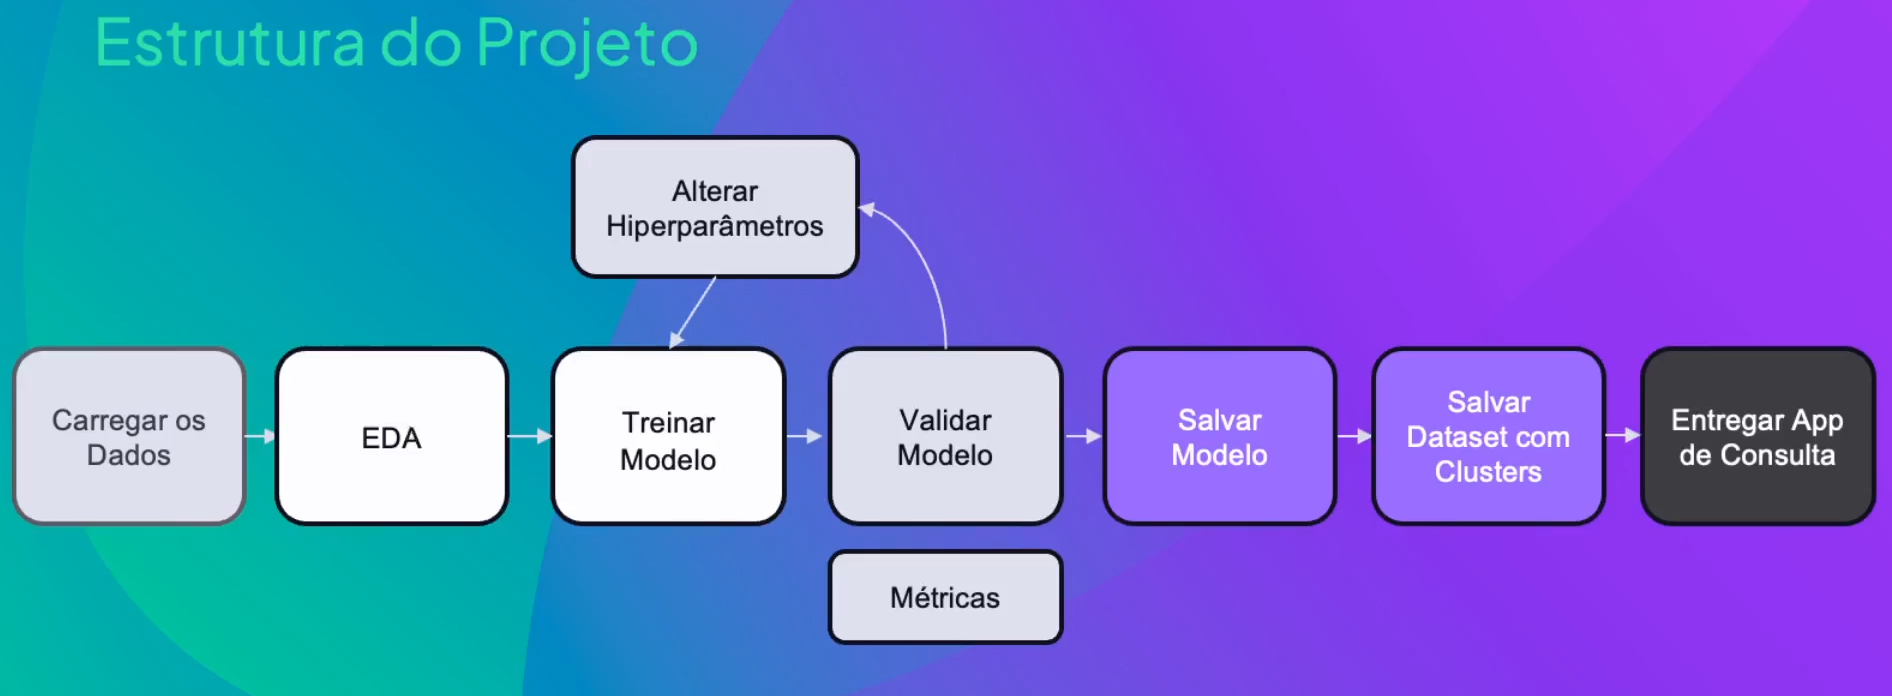

In [2]:
# EDA e visualizacao de dados
import pandas as pd
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt

# ML
from sklearn.cluster import AgglomerativeClustering, BisectingKMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree

# otimizacao
import optuna

### Carregar os Dados

In [3]:
# carregar df
df_laptops = pd.read_csv('./datasets/laptops.csv')

In [17]:
# visualizar o dataset
df_laptops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 991 entries, 0 to 990
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     991 non-null    int64  
 1   brand                     991 non-null    object 
 2   model                     991 non-null    object 
 3   price                     991 non-null    float64
 4   rating                    991 non-null    int64  
 5   processor_brand           991 non-null    object 
 6   processor_tier            991 non-null    object 
 7   num_cores                 991 non-null    int64  
 8   num_threads               991 non-null    int64  
 9   ram_memory                991 non-null    int64  
 10  primary_storage_type      991 non-null    object 
 11  primary_storage_capacity  991 non-null    int64  
 12  gpu_brand                 991 non-null    object 
 13  gpu_type                  991 non-null    object 
 14  is_touch_s

In [7]:
# visualizar os primeiros registros
df_laptops.head(10)

,index,brand,model,price,rating,processor_brand,processor_tier,num_cores,num_threads,ram_memory,primary_storage_type,primary_storage_capacity,gpu_brand,gpu_type,is_touch_screen,display_size,resolution_width,resolution_height,os,year_of_warranty
0,1,tecno,Tecno Megabook T1 Laptop (11th Gen Core i3/ 8G...,287.72,63,intel,core i3,2,4,8,SSD,512,intel,integrated,False,15.6,1920,1080,windows,1
1,2,tecno,Tecno Megabook T1 Laptop (11th Gen Core i7/ 16...,431.64,67,intel,core i7,4,8,16,SSD,1024,intel,integrated,False,15.6,1920,1080,windows,1
2,3,hp,HP Victus 15-fb0157AX Gaming Laptop (AMD Ryzen...,612.86,73,amd,ryzen 5,6,12,8,SSD,512,amd,dedicated,False,15.6,1920,1080,windows,1
3,4,acer,Acer Extensa EX214-53 Laptop (12th Gen Core i5...,479.62,62,intel,core i5,12,16,8,SSD,512,intel,integrated,False,14.0,1920,1080,windows,1
4,5,lenovo,Lenovo V15 82KDA01BIH Laptop (AMD Ryzen 3 5300...,342.77,62,amd,ryzen 3,4,8,8,SSD,512,amd,integrated,False,15.6,1920,1080,windows,1
5,6,apple,Apple MacBook Air 2020 MGND3HN Laptop (Apple M...,851.41,45,apple,m1,8,8,8,SSD,256,apple,apple,False,13.3,2560,1600,mac,1
6,7,infinix,Infinix INBook Y2 Plus Laptop (11th Gen Core i...,419.65,56,intel,core i5,4,8,16,SSD,512,intel,integrated,False,15.6,1920,1080,windows,1
7,8,asus,Asus TUF Gaming F15 FX506HF-HN024W Gaming Lapt...,599.55,70,intel,core i5,6,12,8,SSD,512,nvidia,dedicated,False,15.6,1920,1080,windows,1
8,9,hp,HP 15s-fq5007TU Laptop (12th Gen Core i3/ 8GB/...,443.64,60,intel,core i3,6,8,8,SSD,512,intel,integrated,False,15.6,1920,1080,windows,1
9,10,infinix,Infinix Zerobook 2023 Laptop (13th Gen Core i9...,719.48,71,intel,core i9,14,20,32,SSD,1024,intel,integrated,False,15.6,1920,1080,windows,1


In [8]:
# visualizar os ultimos registros
df_laptops.tail(10)

,index,brand,model,price,rating,processor_brand,processor_tier,num_cores,num_threads,ram_memory,primary_storage_type,primary_storage_capacity,gpu_brand,gpu_type,is_touch_screen,display_size,resolution_width,resolution_height,os,year_of_warranty
981,993,msi,MSI Katana 15 B13VFK-296IN Gaming Laptop (13th...,1439.09,76,intel,core i7,10,16,16,SSD,1024,nvidia,dedicated,False,15.6,1920,1080,windows,2
982,994,asus,Asus Zenbook 14 OLED 2023 UM3402YA-KM551WS Lap...,935.36,68,amd,ryzen 5,6,12,16,SSD,1024,amd,integrated,False,14.0,2880,1800,windows,1
983,995,asus,Asus Vivobook 16 2023 M1605YA-MB551WS Laptop (...,803.44,65,amd,ryzen 5,6,12,16,SSD,1024,amd,integrated,False,16.0,1920,1200,windows,1
984,996,asus,Asus Vivobook 16 2023 M1605YA-MB541WS Laptop (...,719.48,64,amd,ryzen 5,6,12,16,SSD,512,amd,integrated,False,16.0,1920,1200,windows,1
985,997,acer,Acer Nitro 5 AN515-47 NH.QL3SI.003 Gaming Lapt...,905.50,67,amd,ryzen 7,8,16,8,SSD,512,nvidia,dedicated,False,15.6,1920,1080,windows,1
986,998,asus,Asus Vivobook Pro 15 M6500QC-HN542WS Laptop (R...,791.44,68,amd,ryzen 5,6,12,16,SSD,512,nvidia,dedicated,False,15.6,1920,1080,windows,1
987,999,msi,MSI Thin GF63 12VE-070IN Gaming Laptop (12th G...,1103.27,73,intel,core i7,10,16,16,SSD,512,nvidia,dedicated,False,15.6,1920,1080,windows,2
988,1000,asus,Asus Vivobook Go 15 2023 E1504FA-NJ522WS Lapto...,539.58,59,amd,ryzen 5,4,8,8,SSD,512,amd,integrated,False,15.6,1920,1080,windows,1
989,1001,asus,Asus Zenbook 14 2023 UM3402YA-KP541WS Laptop (...,815.43,68,amd,ryzen 5,6,12,16,SSD,512,amd,integrated,False,14.0,2560,1600,windows,1
990,1002,hp,HP Chromebook 15a-na0008TU Laptop (Intel Celer...,251.74,37,intel,celeron,2,2,4,HDD,128,intel,integrated,False,15.6,1366,768,chrome,1


### EDA

In [18]:
# estatisticas das variaveis
df_laptops.describe()

,index,price,rating,num_cores,num_threads,ram_memory,primary_storage_capacity,is_touch_screen,display_size,resolution_width,resolution_height,year_of_warranty
count,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000
mean,505.860747,926.687487,63.931382,8.128153,12.191726,13.047427,610.938446,0.088799,15.171241,2003.503532,1181.227043,1.083754
std,287.899458,688.239764,10.190575,4.215499,5.585115,5.591188,266.927666,0.284597,0.938089,361.965292,263.884019,0.311478
min,1.000000,117.540000,24.000000,2.000000,0.000000,2.000000,32.000000,0.000000,10.100000,1080.000000,768.000000,1.000000
25%,258.500000,522.850000,58.000000,6.000000,8.000000,8.000000,512.000000,0.000000,14.000000,1920.000000,1080.000000,1.000000
50%,507.000000,742.390000,64.000000,8.000000,12.000000,16.000000,512.000000,0.000000,15.600000,1920.000000,1080.000000,1.000000
75%,754.500000,1070.350000,71.000000,10.000000,16.000000,16.000000,512.000000,0.000000,15.600000,1920.000000,1200.000000,1.000000
max,1002.000000,5450.880000,89.000000,24.000000,32.000000,36.000000,2048.000000,1.000000,18.000000,3840.000000,2560.000000,3.000000


In [11]:
# checar variavel year_of_warranty
df_laptops['year_of_warranty'].unique()

array(['1', '2', 'No information', '3'], dtype=object)

In [12]:
# ajustar variavel year_of_warranty
df_laptops.loc[df_laptops['year_of_warranty'] == 'No information', 'year_of_warranty'] = 1
df_laptops['year_of_warranty'] = df_laptops['year_of_warranty'].astype(int)

In [19]:
# transformar variavel booleana em int (is_touch_screen)
df_laptops['is_touch_screen'] = df_laptops['is_touch_screen'].astype(int)

In [20]:
# distribuicao da variavel brand
percentual_brand = df_laptops.value_counts('brand') / len(df_laptops) * 100
px.bar(percentual_brand, color=percentual_brand.index)

In [21]:
# distribuicao da variavel processor_brand
percentual_processor_brand = df_laptops.value_counts('processor_brand') / len(df_laptops) * 100
px.bar(percentual_processor_brand, color=percentual_processor_brand.index)

<Axes: xlabel='price', ylabel='Count'>

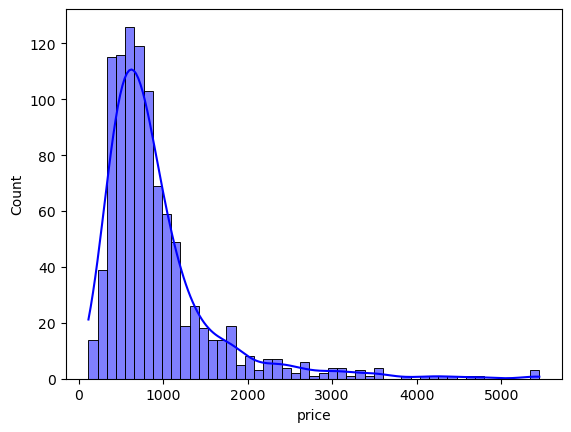

In [27]:
# distribuicao da variavel price
sns.histplot(df_laptops['price'], kde=True, color='blue')

<Axes: xlabel='rating', ylabel='Count'>

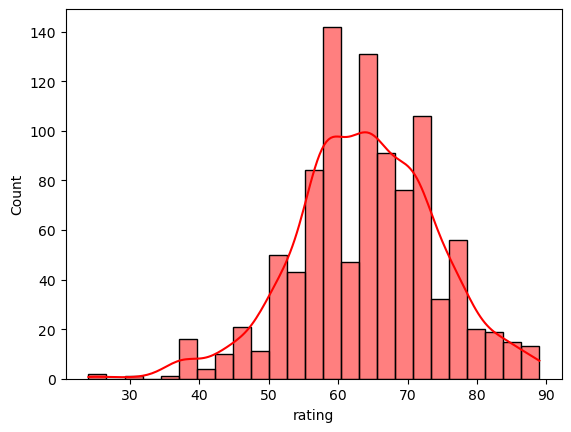

In [33]:
# distribuicao da variavel rating
sns.histplot(df_laptops['rating'], kde=True, color='red')

In [35]:
# plot de distribuicao (boxplot) por brand e price
px.box(df_laptops, x='price', y='brand', color='brand', orientation='h')

In [36]:
# plot de distribuicao (boxplot) por brand e rating
px.box(df_laptops, x='rating', y='brand', color='brand', orientation='h')

In [37]:
# scatterplot de price e rating
px.scatter(df_laptops, x='price', y='rating', color='brand')

### Treinar modelos clustering hierarquico

In [39]:
# selecionar as colunas para clusterizacao
X = df_laptops.copy()

# remover colunas desnecessarias
X.drop(columns=['index', 'model'], axis=1,inplace=True)

In [42]:
# separando variaveis numericas e categoricas
numeric_features = ['price', 'rating', 'num_cores', 'num_threads', 'ram_memory', 'primary_storage_capacity',
                    'display_size', 'resolution_width', 'resolution_height']
categorical_features = ['brand', 'processor_brand', 'gpu_brand', 'gpu_type', 'os']

In [44]:
# definir transformacoes
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

In [45]:
# criar pre processador de transformacoes
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [46]:
# transformar os dados
X_transformed = preprocessor.fit_transform(X)

In [48]:
# visualizar X_transformed
X_transformed

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 13874 stored elements and shape (991, 54)>

In [49]:
def hierarchical_aglomerative_objective(trial):
    # definindo os hiperparametros a serem ajustados
    n_clusters = trial.suggest_int('n_clusters', 10, 150)
    # linkage = criterio de distancia entre dois conjuntos para formar os clusters
    # ward = variancia
    # average = media
    # complete = maxima
    # single = minima
    linkage = trial.suggest_categorical('linkage', ['ward', 'average', 'complete', 'single'])

    # instanciar o modelo
    hierarchical_model = AgglomerativeClustering(linkage=linkage, n_clusters=n_clusters)

    # treinar o modelo e ja executar a clusterizacao
    y = hierarchical_model.fit_predict(X_transformed.toarray())

    # calcular o sillhouete score
    silhouette_avg = silhouette_score(X_transformed, y)

    return silhouette_avg

In [50]:
# criar um estudo no optuna
search_space_ag = {'n_clusters': range(10, 150), 'linkage': ['ward', 'average', 'complete', 'single']}
sampler_ag = optuna.samplers.GridSampler(search_space=search_space_ag)
estudo_ag = optuna.create_study(direction='maximize', sampler=sampler_ag)

[I 2025-04-18 22:12:54,143] A new study created in memory with name: no-name-83426edb-a4ca-4948-868e-c849cfb8ab69


In [51]:
# executar estudo do optuna para aglomerative
estudo_ag.optimize(hierarchical_aglomerative_objective, n_trials=600)

[I 2025-04-18 22:13:31,956] Trial 0 finished with value: -0.0468805711401071 and parameters: {'n_clusters': 94, 'linkage': 'single'}. Best is trial 0 with value: -0.0468805711401071.
[I 2025-04-18 22:13:32,013] Trial 1 finished with value: 0.2216944255575408 and parameters: {'n_clusters': 138, 'linkage': 'complete'}. Best is trial 1 with value: 0.2216944255575408.
[I 2025-04-18 22:13:32,066] Trial 2 finished with value: 0.23985293218676346 and parameters: {'n_clusters': 76, 'linkage': 'ward'}. Best is trial 2 with value: 0.23985293218676346.
[I 2025-04-18 22:13:32,116] Trial 3 finished with value: 0.19534136261412813 and parameters: {'n_clusters': 68, 'linkage': 'complete'}. Best is trial 2 with value: 0.23985293218676346.
[I 2025-04-18 22:13:32,171] Trial 4 finished with value: 0.21968558402008237 and parameters: {'n_clusters': 103, 'linkage': 'average'}. Best is trial 2 with value: 0.23985293218676346.
[I 2025-04-18 22:13:32,214] Trial 5 finished with value: 0.09841825566449644 and p

In [54]:
# mostrar melhor configuracao do optuna (aglomerative)
best_params_ag = estudo_ag.best_params

print(f'Clusters = {best_params_ag['n_clusters']}')
print(f'Clusters = {best_params_ag['linkage']}')

Clusters = 149
Clusters = ward


In [55]:
def hierarchical_divisive_objective(trial):
    # definindo os hiperparametros a serem ajustados
    n_clusters = trial.suggest_int('n_clusters', 10, 150)

    # instanciar o modelo
    hierarchical_model = BisectingKMeans(n_clusters=n_clusters)

    # treinar o modelo e ja executar a clusterizacao
    y = hierarchical_model.fit_predict(X_transformed.toarray())

    # calcular o sillhouete score
    silhouette_avg = silhouette_score(X_transformed, y)

    return silhouette_avg

In [56]:
# criar um estudo no optuna
search_space_di = {'n_clusters': range(10, 151)}
sampler_di = optuna.samplers.GridSampler(search_space=search_space_di)
estudo_di = optuna.create_study(direction='maximize', sampler=sampler_di)

[I 2025-04-18 22:20:32,957] A new study created in memory with name: no-name-771552c5-9029-417e-8d80-b53688420a96


In [57]:
# executar estudo do optuna para aglomerative
estudo_di.optimize(hierarchical_divisive_objective, n_trials=200)

c:\Users\guilh\miniconda3\envs\Projeto_ML\Lib\site-packages\sklearn\cluster\_bisect_k_means.py:256: UserWarning:

BisectingKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

[I 2025-04-18 22:21:02,131] Trial 0 finished with value: 0.14511228950463212 and parameters: {'n_clusters': 55}. Best is trial 0 with value: 0.14511228950463212.
c:\Users\guilh\miniconda3\envs\Projeto_ML\Lib\site-packages\sklearn\cluster\_bisect_k_means.py:256: UserWarning:

BisectingKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

[I 2025-04-18 22:21:02,371] Trial 1 finished with value: 0.16904234655389785 and parameters: {'n_clusters': 70}. Best is trial 1 with value: 0.16904234655389785.
c:\Users\guilh\miniconda3\envs\Projeto_ML\Lib\site-packages\skle

In [58]:
# mostrar melhor configuracao do optuna (aglomerative)
best_params_di = estudo_di.best_params

print(f'Clusters = {best_params_di['n_clusters']}')

Clusters = 144


In [59]:
# criar modelo com melhor configuracao (aglomerative)
best_model = AgglomerativeClustering(
    n_clusters=best_params_ag['n_clusters'],
    linkage=best_params_ag['linkage']
)

In [60]:
# treinar modelo
best_model.fit(X_transformed.toarray())

AgglomerativeClustering(n_clusters=149)

In [61]:
# verificar silhouette score
best_score = silhouette_score(X_transformed, best_model.labels_)
best_score

np.float64(0.32745480721431686)

In [62]:
# criar coluna com cluster escolhido no dataframe original
df_laptops['cluster'] = best_model.labels_

### Visualizar Resultados

In [65]:
# mostrar chart com trials do optuna
fig = optuna.visualization.plot_optimization_history(estudo_ag)
fig.show()

In [66]:
# treinar modelo com scipy
modelo_de = linkage(X_transformed.toarray(), method=best_params_ag['linkage'], optimal_ordering=True)

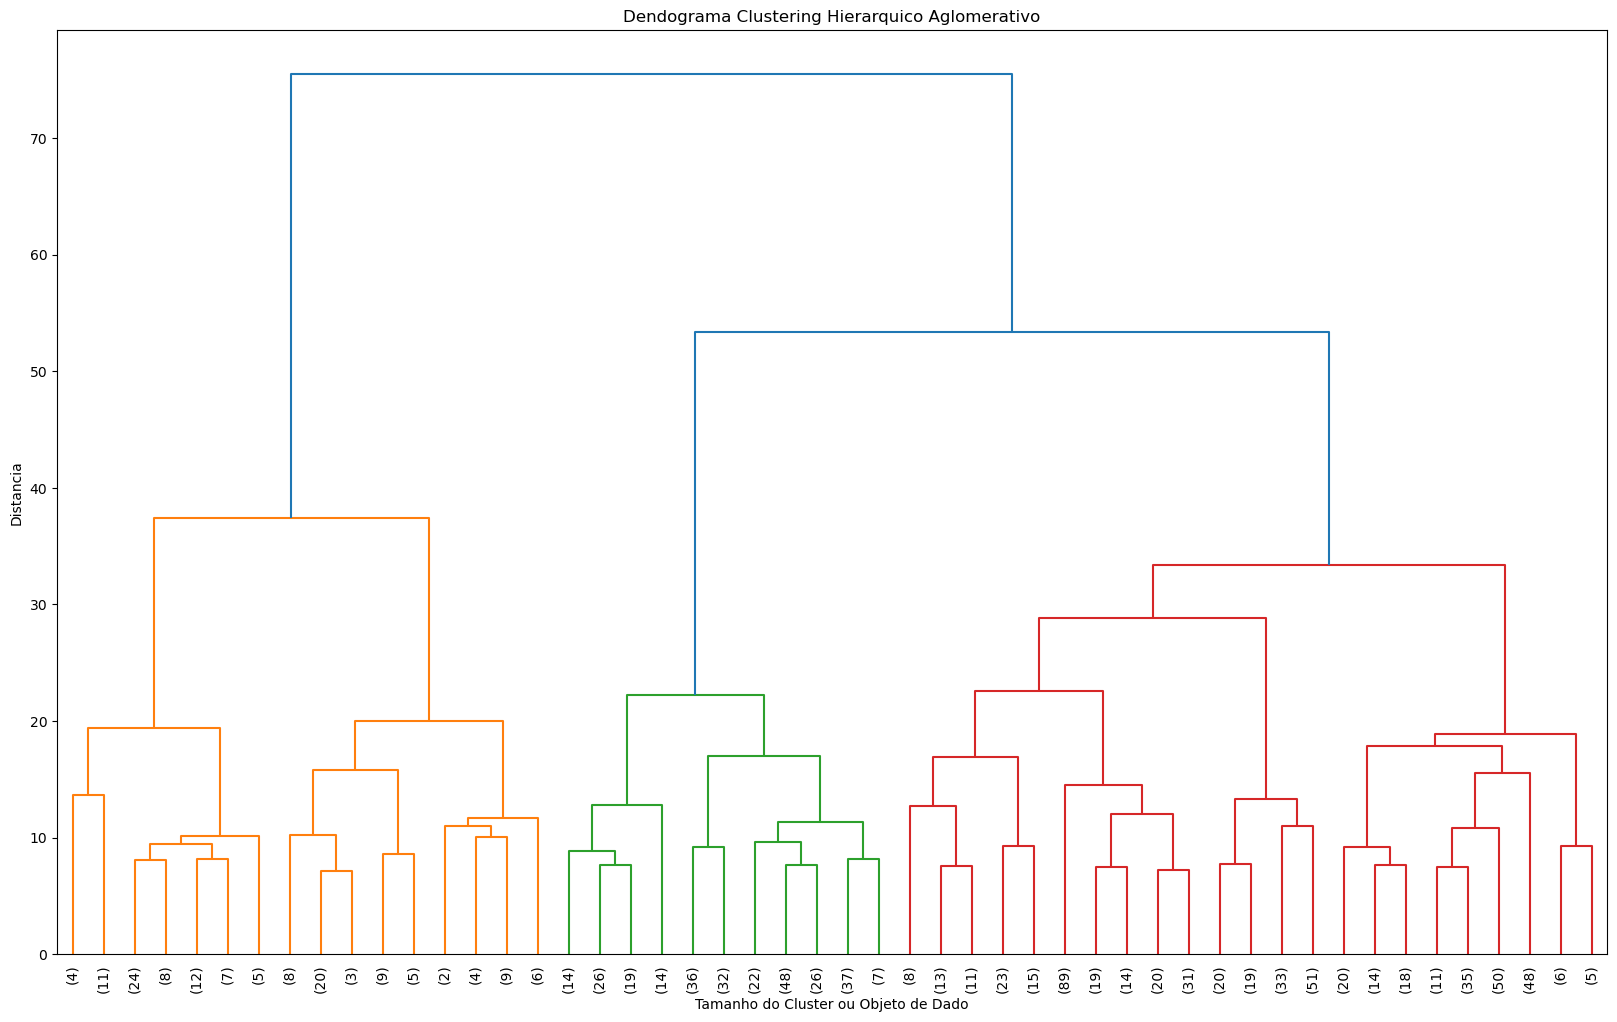

In [73]:
# mostrar dendograma
plt.figure(figsize=(20,12))
dendrogram(modelo_de, truncate_mode='lastp', p=50, leaf_rotation=90, leaf_font_size=10)
plt.title('Dendograma Clustering Hierarquico Aglomerativo')
plt.xlabel('Tamanho do Cluster ou Objeto de Dado')
plt.ylabel('Distancia')
plt.show()

In [76]:
# cortar dendograma
clusters_de_scipy = cut_tree(modelo_de, height=32)
len(np.unique(clusters_de_scipy))

5

In [78]:
# cruzamento entre brand e price apresentando os clusters
px.scatter(df_laptops, x='cluster', y='price', color='brand')

In [79]:
# cruzamento entre brand e price apresentando os clusters
px.scatter(df_laptops, x='brand', y='price', color='cluster')

In [80]:
# cruzamento entre brand e rating apresentando os clusters
px.scatter(df_laptops, x='brand', y='rating', color='cluster')

In [81]:
# cruzamento entre brand e rating apresentando os clusters
px.scatter(df_laptops, x='cluster', y='rating', color='brand')

In [83]:
# Distribuição da variável cluster
percentual_cluster = df_laptops.value_counts('cluster') / len(df_laptops) * 100
px.bar(percentual_cluster, color=percentual_cluster.index)

In [84]:
# Distribuição da variável cluster
qtde_cluster = df_laptops.value_counts('cluster')
px.bar(qtde_cluster, color=qtde_cluster.index)

### Salvar Modelo, PreProcessor e CSV Atualizado

In [85]:
# salvar modelo e preprocessor
import joblib

# salvar o modelo
joblib.dump(best_model, './modelo_clusterizacao_laptops.pkl')

# salvar o preprocessor
joblib.dump(preprocessor, './preprocessor_clusterizacao_laptops.pkl')

['./preprocessor_clusterizacao_laptops.pkl']

In [86]:
# salvar CSV atualizado com dados de cluster
df_laptops.to_csv('./datasets/clusterizacao_laptops.csv', index=False)